# Policy Scenario Notebook

#### Setup

In [1]:
%pip install -r requirements.txt

  Using cached cfedemands-0.6.4.dev0-py2.py3-none-any.whl.metadata (1.6 kB)
  Using cached ConsumerDemands-0.4.3.dev0-py2.py3-none-any.whl.metadata (1.2 kB)
  Using cached eep153_tools-0.12.4-py2.py3-none-any.whl.metadata (363 bytes)
  Using cached python_gnupg-0.5.4-py2.py3-none-any.whl.metadata (2.0 kB)
  Using cached gspread_pandas-3.3.0-py2.py3-none-any.whl.metadata (10 kB)
  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)
Using cached cfedemands-0.6.4.dev0-py2.py3-none-any.whl (45 kB)
Using cached ConsumerDemands-0.4.3.dev0-py2.py3-none-any.whl (12 kB)
Using cached eep153_tools-0.12.4-py2.py3-none-any.whl (4.9 kB)
Using cached python_gnupg-0.5.4-py2.py3-none-any.whl (21 kB)
Using cached gspread_pandas-3.3.0-py2.py3-none-any.whl (27 kB)
Using cached fsspec-2025.3.2-py3-none-any.whl (194 kB)
  Attempting uninstall: gspread_pandas
    Found existing installation: gspread-pandas 2.2.3
    Uninstalling gspread-pandas-2.2.3:
      Successfully uninstalled gspread-pandas-2

In [3]:
import pandas as pd
import cfe.regression as rgsn
import numpy as np
import matplotlib.pyplot as plt
from eep153_tools.sheets import read_sheets

In [4]:
r = rgsn.read_pickle('Data/tanz_rgsn')

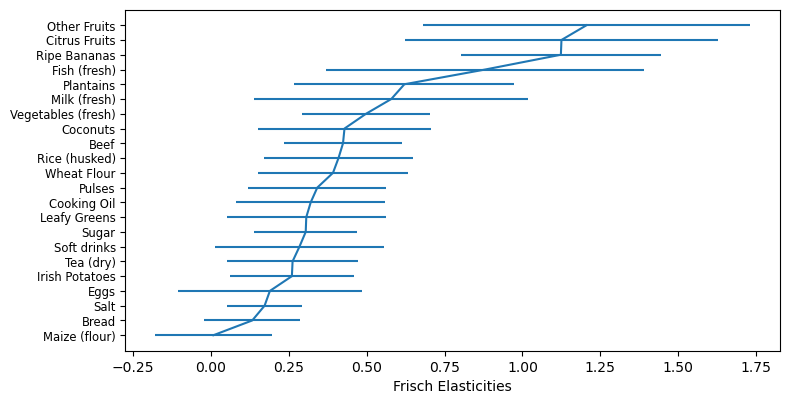

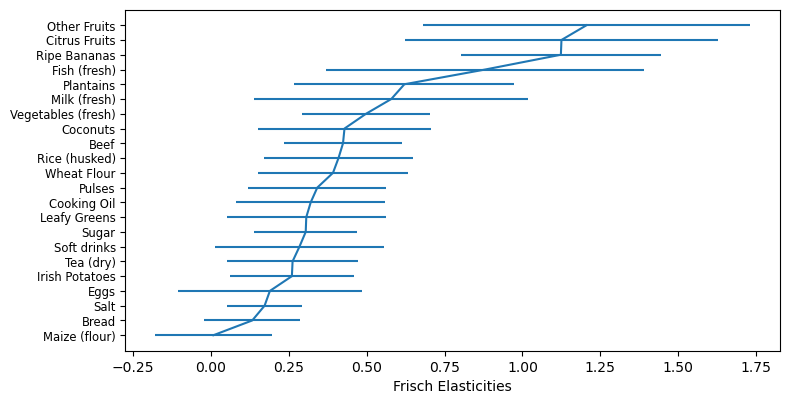

In [10]:
r.graph_beta()

In [12]:
pbar = pd.read_pickle('Data/pbar.pkl')   # still a Series with the same index & dtypes
fct  = pd.read_pickle('Data/fct.pkl')    # DataFrame intact
rdi  = pd.read_pickle('Data/rdi.pkl')
x = pd.read_pickle('Data/x.pkl')

In [13]:
Tanz_data = 'https://docs.google.com/spreadsheets/d/1t7oTB6FAdzu34SdNKCMK8rUoin8TeeKq1wt2fu4VBho/edit?usp=sharing'

In [14]:
d = read_sheets(Tanz_data, sheet = 'Household Characteristics')
d = d[d['t'] == '2020-21']
d.set_index(['i','t','m'],inplace=True)
d = d.drop(columns = ['log HSize'])

In [15]:
demo_cols   = d.columns.intersection(rdi.columns)
d_demo      = d[demo_cols]               # households × demographics
rdi_demo    = rdi[demo_cols].T           # demographics × nutrients

# each household’s daily nutrient needs:
hh_daily_req = d_demo.dot(rdi_demo)      # index=(i,t,m), columns=nutrients


## Helper Functions and Setup

In [20]:
# 1) Load raw Tanzania data
TANZ_ID = "1t7oTB6FAdzu34SdNKCMK8rUoin8TeeKq1wt2fu4VBho"

# Expenditures: Series idx=(i,t,m,j)
x = (read_sheets(TANZ_ID, sheet="Food Expenditures (2020-21)")
     .set_index(["i","t","m","j"])['Expenditure'])
x = x.replace(0, np.nan)

# Prices: Series idx=(t,m,j)
p = (read_sheets(TANZ_ID, sheet="Food Prices (2020-21)")
     .query("u.str.lower()=='kg'", engine='python')
     .set_index(["t","m","j"])['Price'])
p = p.replace(0, np.nan)
p_df = p.unstack('j')  # DataFrame idx=(t,m), cols=goods

# FCT: DataFrame idx=good, cols=nutrients
fct = (read_sheets(TANZ_ID, sheet="FCT")
       .set_index('j')
       .apply(pd.to_numeric, errors='coerce'))

# Name mapping placeholder
NAME_MAP = {'fish (fresh)': 'fresh fish', 'leafy greens': 'spinach', 'milk (fresh)': 'fresh milk', 'other fruits': 'canned fruits', 
                    'pulses': 'peas, beans, lentils and other pulses', 'vegetables (fresh)': 'spinach, cabbage, other green vegetables', 'wheat flour': 'wheat (flour)'}

def clean(idx: pd.Index) -> pd.Index:
    idx2 = idx.str.strip().str.lower()
    return idx2.map(lambda x: NAME_MAP.get(x, x))

# Clean goods names
fct.index = clean(fct.index)
p_df.columns = clean(p_df.columns)
x.index = x.index.set_levels(
    clean(x.index.levels[3]), level=3)

# 2) Baseline nutrient intakes from observed expenditures

def compute_baseline_nutrients(x: pd.Series, p_df: pd.DataFrame, fct: pd.DataFrame) -> pd.DataFrame:
    """
    Returns baseline nutrient intakes per household (i,t,m).
    Uses observed expenditures, observed prices, and FCT.

    x: Series idx=(i,t,m,j) of expenditures
    p_df: DataFrame idx=(t,m), cols=j of prices per kg
    fct: DataFrame idx=j, cols=nutrients per kg
    """
    # pivot expenditures to DataFrame idx=(i,t,m), cols=j
    x_df = x.unstack('j')
    # quantities = expenditure / price
    q = x_df.div(p_df, axis=0)
    # keep only goods that have an FCT
    goods = fct.index.intersection(q.columns)
    q = q[goods].fillna(0)
    # nutrient intakes = quantities · FCT
    return q.dot(fct.loc[goods])

# 3) Scenario nutrient intakes via demand system

def compute_scenario_nutrients(
    result,
    budgets: pd.Series,
    scenariopbar: pd.Series,
    fct: pd.DataFrame
) -> pd.DataFrame:
    """
    Returns scenario nutrient intakes per household (i,t,m).
    Uses model demands at household budgets and scenario prices.

    result: fitted cfe.Regression
    budgets: Series idx=(i,t,m) of total food budgets
    scenariopbar: Series idx=j of new prices per good
    fct: DataFrame idx=j, cols=nutrients per kg
    """
    # 1) compute household‐specific Marshallian quantities
    demands_list = []
    idx_list = []
    for hh, bud in budgets.items():
        q_hh = result.demands(bud, scenariopbar)
        demands_list.append(q_hh)
        idx_list.append(hh)
    q_df = pd.DataFrame(demands_list, index=pd.MultiIndex.from_tuples(idx_list, names=budgets.index.names))
    # 2) clean and keep only FCT goods
    q_df.columns = clean(q_df.columns)
    goods = fct.index.intersection(q_df.columns)
    q_df = q_df[goods].fillna(0)
    # 3) nutrient intakes per hh = q_df · FCT
    return q_df.dot(fct.loc[goods])

# Example usage:
# baseline_intakes = compute_baseline_nutrients(x, p_df, fct)
# # build and clean pbar/scenario pbar...
# budgets = baseline_intakes.sum(axis=1)  # or x_df.sum(axis=1)
# scenario_intakes = compute_scenario_nutrients(result, budgets, scenariopbar, fct)


In [21]:
from typing import Optional

def plot_adequacy_histograms(
    baseline_intakes: pd.DataFrame,
    scenario_intakes: Optional[pd.DataFrame],
    hh_period_req: pd.DataFrame,   # ← requirement over recall period
    nutrient: str,
    bins: int = 60,
    cap_percentile: float = 99,
    figsize: tuple = (10, 6),
    alpha: float = 0.6
):
    """
    Plot nutritional adequacy ratios for one nutrient.
    Optionally overlay a scenario.  Then print the share of households
    at or above adequacy (ratio ≥1).
    """
    # 1) compute baseline ratios
    b = (baseline_intakes[nutrient] / hh_daily_req[nutrient]).dropna()
    b = b[b > 0]

    # 2) compute scenario ratios if given
    if scenario_intakes is not None:
        s = (scenario_intakes[nutrient] / hh_daily_req[nutrient]).dropna()
        s = s[s > 0]

    # 3) determine cap at given percentile
    if scenario_intakes is None:
        all_vals = b.values
    else:
        all_vals = np.concatenate([b.values, s.values])
    cap = np.percentile(all_vals, cap_percentile)

    # 4) build bin edges
    edges = np.linspace(0, cap, bins + 1)

    # 5) plot
    plt.figure(figsize=figsize)
    plt.hist(b, bins=edges, alpha=alpha, label='Baseline')
    if scenario_intakes is not None:
        plt.hist(s, bins=edges, alpha=alpha, label='Scenario')
    plt.xlim(0, cap)
    plt.title(f"Nutritional Adequacy Ratios for {nutrient.title()}")
    plt.xlabel("Intake ÷ Requirement")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    # 6) compute and print shares ≥1
    def share_at_or_above(series: pd.Series) -> float:
        return (series >= 1).sum() / len(series)

    baseline_share = share_at_or_above(b)
    print(f"Baseline:  {baseline_share:.1%} of households ≥ 1.0")

    if scenario_intakes is not None:
        scenario_share = share_at_or_above(s)
        print(f"Scenario:  {scenario_share:.1%} of households ≥ 1.0")

In [22]:
xhat    = r.predicted_expenditures()                 # Series indexed by (i,t,m,j)

# 3) if you want it as a wide DataFrame: 
xhat_df = xhat.unstack('j')                                # idx=(i,t,m), cols=goods

In [23]:
budgets = xhat_df.sum(axis=1)

In [24]:
scenariopbar = []

## Define Scenario!
Policy Input Below, apply as new PBar and run the rest of notebook for graph updates

In [25]:
import numpy as np
import pandas as pd
from eep153_tools.sheets import read_sheets
# assume pbar and fct are already loaded in this namespace

# 0) Name mapping placeholder (fill in as needed)
NAME_MAP = {'fish (fresh)': 'fresh fish', 'leafy greens': 'spinach', 'milk (fresh)': 'fresh milk', 'other fruits': 'canned fruits', 
                    'pulses': 'peas, beans, lentils and other pulses', 'vegetables (fresh)': 'spinach, cabbage, other green vegetables', 'wheat flour': 'wheat (flour)'}

def clean(idx: pd.Index) -> pd.Index:
    """Strip, lowercase, and apply NAME_MAP to an Index."""
    idx2 = idx.str.strip().str.lower()
    return idx2.map(lambda x: NAME_MAP.get(x, x))

# 1) Clean & map baseline price vector pbar
pbar.index = clean(pbar.index)
pbar = pbar.rename(index=NAME_MAP)

# 2) Build per-food multiplier widgets from cleaned pbar.index
import ipywidgets as widgets
from IPython.display import display, clear_output
from ipywidgets import GridBox, Label, Layout

food_mult_widgets = {
    j: widgets.FloatText(value=1.0, description='', layout=Layout(width='100px'))
    for j in pbar.index
}

# 3) Global multiplier widget
global_mult = widgets.FloatText(value=1.0, description='Global ×', layout=Layout(width='200px'))

# 4) Per-nutrient tax widgets from fct.columns
nut_tax_widgets = {
    n: widgets.FloatText(value=0.0, description=n, layout=Layout(width='300px'))
    for n in fct.columns
}

# 5) Reset button & output area
reset_button = widgets.Button(description='Reset All', button_style='warning')
output = widgets.Output()

# 6) Layout grid of food multipliers
labels = [Label(value=str(j), layout=Layout(width='200px')) for j in pbar.index]
inputs = [food_mult_widgets[j] for j in pbar.index]
grid = GridBox(
    children=[val for pair in zip(labels, inputs) for val in pair],
    layout=Layout(
        grid_template_columns='200px 100px',
        grid_row_gap='4px',
        grid_column_gap='8px',
        overflow='auto',
        height='600px',
        width='320px'
    )
)

# 7) Compute updated pbar with mapping
def compute_updated_pbar():
    # read widget values
    fm = pd.Series({j: w.value for j, w in food_mult_widgets.items()}, index=pbar.index)
    sys = global_mult.value
    nt  = pd.Series({n: w.value for n, w in nut_tax_widgets.items()}, index=fct.columns)
    # base adjustment
    base_price = pbar * fm * sys
    # nutrient tax vector
    tax_vec = (
        fct.mul(nt, axis=1)
           .sum(axis=1)
           .reindex(pbar.index)
           .fillna(0.0)
    )
    newp = base_price + tax_vec
    # clean & map new index
    newp.index = clean(newp.index)
    newp = newp.rename(index=NAME_MAP)
    return newp

# 8) Update callback to display newp
def update_prices(change=None):
    with output:
        clear_output(wait=True)
        newp = compute_updated_pbar()
        display(newp)

# 9) Reset widgets callback
def on_reset(_):
    global_mult.value = 1.0
    for w in food_mult_widgets.values(): w.value = 1.0
    for w in nut_tax_widgets.values(): w.value = 0.0
    update_prices()

reset_button.on_click(on_reset)

# 10) Apply pbar button
enable_btn = widgets.Button(description='Apply as new pbar', button_style='success')
def on_apply(_):
    global scenariopbar
    scenariopbar = compute_updated_pbar()
    print("scenariopbar updated with mapping applied.")
enable_btn.on_click(on_apply)

# 11) Wire observers
for w in list(food_mult_widgets.values()) + [global_mult] + list(nut_tax_widgets.values()):
    w.observe(update_prices, names='value')

# 12) Build tabs
tab_food = widgets.VBox([global_mult, grid], layout=Layout(align_items='flex-start'))
tab_nut  = widgets.VBox(list(nut_tax_widgets.values()) + [reset_button], layout=Layout(overflow='auto', height='600px'))
tabs     = widgets.Tab([tab_food, tab_nut])
tabs.set_title(0, "Food Multipliers")
tabs.set_title(1, "Nutrient Tax/Subsidy")

# 13) Display UI
display(enable_btn, reset_button)
display(tabs, output)
update_prices()


Button(button_style='success', description='Apply as new pbar', style=ButtonStyle())

Button(button_style='warning', description='Reset All', style=ButtonStyle())

Output()

In [46]:
scenario_fct = fct.copy()

item           = 'eggs'         # use your cleaned‐up name here
nut            = 'Vitamin A'    # make sure this is lowercase to match fct.columns
new_va_per_kg  = 12393          # µg per kg

scenario_fct.loc[item, nut] = new_va_per_kg

In [50]:
# 1) Build weekly req once:
hh_weekly_req    = hh_daily_req * 7

# 2) Get weekly intakes (no /7 here!)
baseline_intakes = compute_scenario_nutrients(r, budgets, pbar,        fct)/7
scenario_intakes = compute_scenario_nutrients(r, budgets, scenariopbar, scenario_fct)/7

In [51]:
import ipywidgets as widgets
from IPython.display import display

# 1) make a sorted list of available nutrients
nutrients = sorted(baseline_intakes.columns.tolist())

# 2) build two controls: a dropdown for nutrient, a slider for # of bins
nut_widget = widgets.Dropdown(
    options=nutrients,
    value=nutrients[0],
    description="Nutrient:",
    style={'description_width':'initial'}
)
bin_widget = widgets.IntSlider(
    value=60, min=10, max=200, step=10,
    description="Bins:",
    style={'description_width':'initial'}
)

# 3) define a small wrapper that calls your plotter
def _update(nutrient, bins):
    plot_adequacy_histograms(
        baseline_intakes,
        scenario_intakes,
        hh_weekly_req,
        nutrient=nutrient,
        bins=bins
    )

# 4) wire it up
ui  = widgets.VBox([nut_widget, bin_widget])
out = widgets.interactive_output(_update, {
    'nutrient': nut_widget,
    'bins':      bin_widget
})

display(ui, out)


Output()

In [1]:
r.graph_betas

NameError: name 'r' is not defined